Basic analyses of behavior in the FHT task. 

In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import entropy

# 1. Load and prep behavioral data

In [5]:
behav_path = os.getcwd() + '/ProcessedData/AllData.csv' # this expects ProcessedData to be in the analysis repo
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 23) & (behav_data['Game'] == 1)])

# change subj to int
behav_data['Subj'] = behav_data['Subj'].astype(int)

## Add trial-within-game variable.
behav_data['WithinGameTrial'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Outcome,Dim,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,WithinGameTrial
0,23,1,1,1,6,8,2,5,7,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,1.12700,1
1,23,2,1,2,5,7,1,4,8,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,1.08580,2
2,23,3,1,3,4,7,2,5,9,1,...,0.0,1,2,NaN,NaN,0.0,NaN,NaN,1.24420,3
3,23,4,1,1,4,7,2,5,8,3,...,0.0,1,2,NaN,NaN,1.0,NaN,NaN,0.47509,4
4,23,5,1,1,6,8,2,4,7,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.88090,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.61252,16
15196,71,397,20,1,5,8,2,4,9,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.89898,17
15197,71,398,20,1,6,7,2,4,9,3,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.59331,18
15198,71,399,20,1,6,7,3,5,8,2,...,1.0,1,2,NaN,NaN,1.0,NaN,NaN,0.52019,19


In [6]:
subj_id = 39
block = 10
trial = 7
sub = behav_data.loc[behav_data['Subj'] == subj_id]
sub = sub.loc[sub['Trial'] == (block-1)*40 + trial]
sub[['Chosen1', 'Chosen2', 'Chosen3', 'Feat']]

,Chosen1,Chosen2,Chosen3,Feat
5566,3.0,5.0,8.0,5


# 2. Plot general learning and accuracy

## 2a. Plot general learning curve

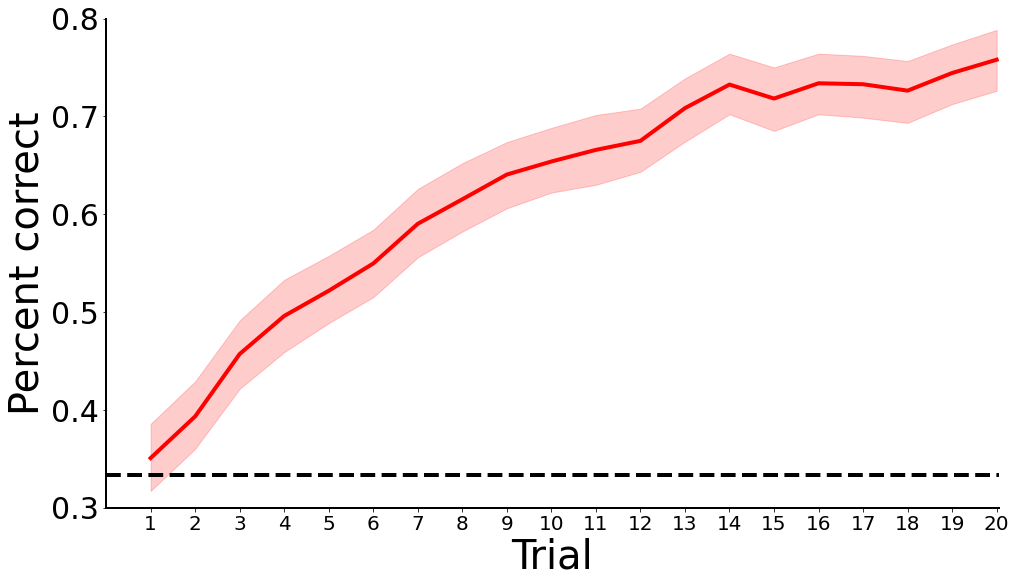

In [7]:
df = pd.melt(behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df, lw=4, legend=False, color='red')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0.3,0.8])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

## 2b. Plot general number correct in last 6

In [107]:
def getLastSixGames(behav_data, game_length):
    last_6 = np.arange(game_length-6,game_length)+1

    # only grab last six trials of each game
    df_last_6 = behav_data.loc[behav_data['WithinGameTrial'].isin(last_6)].reset_index(drop=True)
    df_last_6 = df_last_6[['Subj','Game','WithinGameTrial','Correct']]

    ## Sum corrects in last 6 within game.
    df_last_6 = df_last_6.groupby(['Subj','Game'])['Correct'].sum().reset_index()

    ## Count and normalize by number of games.
    df_last_6 = df_last_6.groupby(['Subj','Correct']).count().unstack(fill_value=0).stack().reset_index()
    df_last_6['Game'] = df_last_6['Game'] / n_games
    
    return df_last_6

In [108]:
def getAverageLastSixTrials(behav_data, game_length):
    last_6 = np.arange(game_length-6,game_length)+1

    # only grab last six trials of each game
    df_last_6 = behav_data.loc[behav_data['WithinGameTrial'].isin(last_6)].reset_index(drop=True)
    df_last_6 = df_last_6[['Subj','Game','WithinGameTrial','Correct']]

    ## Sum corrects in last 6 within game.
    df_last_6 = df_last_6.groupby(['Subj','Game'])['Correct'].sum().reset_index()
    
    ## Get average number of games correct in last six.
    df_last_6['AverageNumberCorrect'] = df_last_6['Correct']
    df_last_6 = df_last_6.groupby(['Subj'])['AverageNumberCorrect'].sum().reset_index()
    df_last_6['AverageNumberCorrect'] = df_last_6['AverageNumberCorrect']/20

    
    return df_last_6


In [105]:
last_6 = np.arange(game_length-6,game_length)+1

# only grab last six trials of each game
df_last_6 = behav_data.loc[behav_data['WithinGameTrial'].isin(last_6)].reset_index(drop=True)
df_last_6 = df_last_6[['Subj','Game','WithinGameTrial','Correct']]

## Sum corrects in last 6 within game.
df_last_6 = df_last_6.groupby(['Subj','Game'])['Correct'].sum().reset_index()

## Count and normalize by number of games.
df_last_6['AverageNumberCorrect'] = df_last_6['Correct']
df_last_6 = df_last_6.groupby(['Subj'])['AverageNumberCorrect'].sum().reset_index()
df_last_6['AverageNumberCorrect'] = df_last_6['AverageNumberCorrect']/20

In [106]:
df_last_6

,Subj,AverageNumberCorrect
0,23,4.90
1,26,5.10
2,27,4.40
3,28,5.05
4,29,3.65
5,30,3.65
6,31,4.80
7,33,5.05
8,34,3.50
9,35,4.60


In [109]:
df_last_6_games = getLastSixGames(behav_data, game_length)

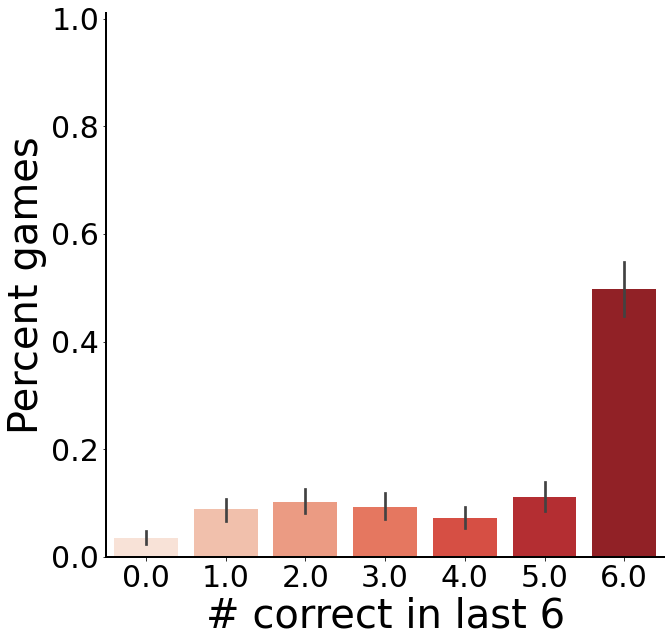

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x="Correct", y="Game", data=df_last_6, palette="Reds",ci=95);
sns.despine()
ax.set_ylim([0,1.01])
xl = ax.set_xlabel('# correct in last 6',fontsize = 40);
yl = ax.set_ylabel('Percent games',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=30)

In [111]:
average_last_six = getAverageLastSixTrials(behav_data, game_length)
average_last_six

,Subj,AverageNumberCorrect
0,23,4.90
1,26,5.10
2,27,4.40
3,28,5.05
4,29,3.65
5,30,3.65
6,31,4.80
7,33,5.05
8,34,3.50
9,35,4.60


In [161]:
# if the percentage of games that the subject had 5 or 6 correct in the last 6 trials is above 65%, then the game is learned
learned = average_last_six.loc[average_last_six['AverageNumberCorrect'] >= 4.8].reset_index(drop=True)
learned_sub_ids = learned.Subj.to_numpy()
notlearned = average_last_six.loc[average_last_six['AverageNumberCorrect'] < 4.8].reset_index(drop=True)
notlearned_sub_ids = notlearned.Subj.to_numpy()
learned_df = behav_data.copy()
notlearned_df = behav_data.copy()

# store learned information in new dataframe and in big dataframe
for subj in learned_sub_ids:
    notlearned_df = notlearned_df[notlearned_df.Subj != subj]
    behav_data.loc[behav_data['Subj'] == subj,'LearnedFeat'] = True
for subj in notlearned_sub_ids:
    learned_df = learned_df[learned_df.Subj != subj]
    behav_data.loc[behav_data['Subj'] == subj,'LearnedFeat'] = False

In [162]:
learned_sub_ids

array([23, 26, 28, 31, 33, 36, 38, 43, 45, 47, 55, 57, 63, 66])

In [163]:
notlearned_sub_ids

array([27, 29, 30, 34, 35, 37, 39, 40, 41, 42, 44, 46, 49, 53, 54, 58, 60,
       61, 62, 67, 68, 69, 70, 71])

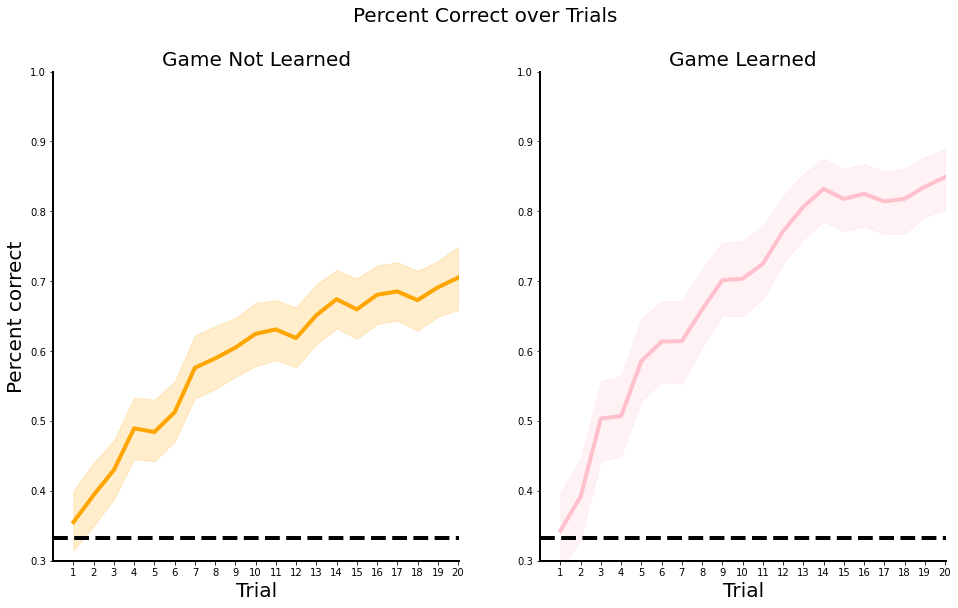

In [164]:
df_learned = pd.melt(learned_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_notlearned = pd.melt(notlearned_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Percent Correct over Trials',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)
ax1.axhline(y=1/3, color='k', lw=4, linestyle='--');
ax2.axhline(y=1/3, color='k', lw=4, linestyle='--');

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_notlearned, lw=4, legend=False, color='orange')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_learned, lw=4, legend=False, color='pink')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0.3,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0.3, 1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Percent correct',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')
# plt.xticks(fontsize=20);
# plt.yticks(fontsize=20);

# 3. Plot learning curves by age

In [165]:
# import agemap
raw_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/'
age_df = pd.read_csv(raw_data_dir + 'SubDemographics.csv').dropna()
age_df['Subj_id'] = age_df['Subj_id'].astype(int)
ageMap = age_df[['Age','Subj_id']] # .set_index('Subj_id')
ageMap

,Age,Subj_id
0,15.12,23
1,15.39,24
2,19.79,25
3,23.32,26
4,14.58,27
5,14.00,28
6,16.73,29
7,17.48,30
8,17.64,31
9,30.36,32


In [166]:
# add age related columns in behavioral dataframe
behav_data["Adult"] = False
behav_data['Age'] = np.nan
for index, row in behav_data.iterrows():
    subj_id = int(row.Subj)
    age = ageMap.loc[ageMap['Subj_id'] == subj_id].Age.item()
    if age < 10:
        behav_data.drop([index]) # remove 
        continue
    behav_data.loc[index, "Age"] = age
    if age >= 18:
        behav_data.loc[index, "Adult"] = True
behav_data

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feat,CenterDim,CenterFeat,Correct,LearnedFeat,PoL,RT,WithinGameTrial,Adult,Age
0,23,1,1,1,6,8,2,5,7,3,...,2,NaN,NaN,1.0,True,NaN,1.12700,1,False,15.12
1,23,2,1,2,5,7,1,4,8,3,...,2,NaN,NaN,1.0,True,NaN,1.08580,2,False,15.12
2,23,3,1,3,4,7,2,5,9,1,...,2,NaN,NaN,0.0,True,NaN,1.24420,3,False,15.12
3,23,4,1,1,4,7,2,5,8,3,...,2,NaN,NaN,1.0,True,NaN,0.47509,4,False,15.12
4,23,5,1,1,6,8,2,4,7,3,...,2,NaN,NaN,1.0,True,NaN,0.88090,5,False,15.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15195,71,396,20,1,5,7,3,4,9,2,...,2,NaN,NaN,1.0,False,NaN,0.61252,16,True,22.52
15196,71,397,20,1,5,8,2,4,9,3,...,2,NaN,NaN,1.0,False,NaN,0.89898,17,True,22.52
15197,71,398,20,1,6,7,2,4,9,3,...,2,NaN,NaN,1.0,False,NaN,0.59331,18,True,22.52
15198,71,399,20,1,6,7,3,5,8,2,...,2,NaN,NaN,1.0,False,NaN,0.52019,19,True,22.52


In [142]:
# split the dataframe into adult and adolescent dataframes
adult_behav_data = behav_data.loc[behav_data['Adult']]
adole_behav_data = behav_data.loc[behav_data['Adult'] == False]

## 3a. Plot age-related learning curves

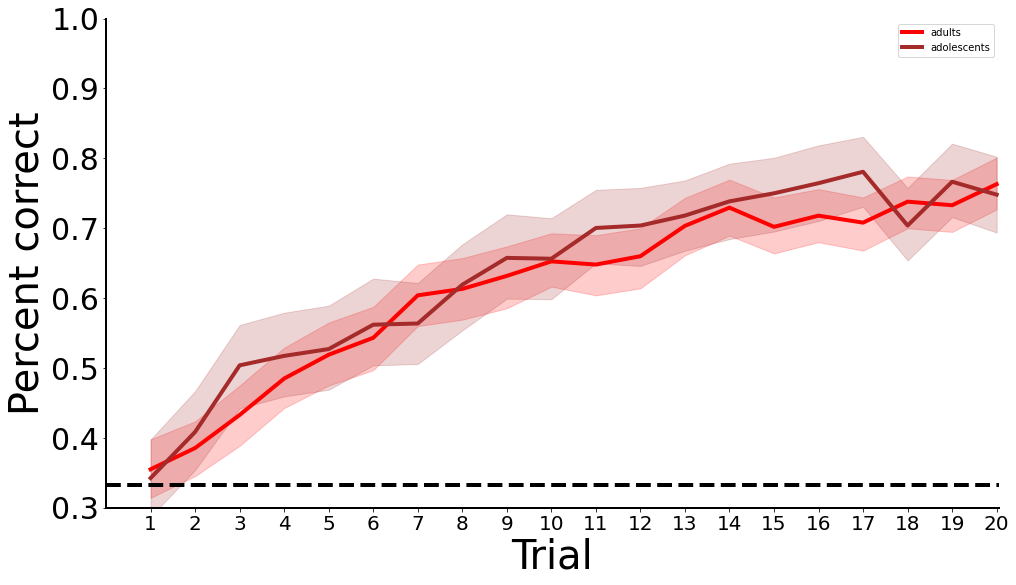

In [143]:
df_adult = pd.melt(adult_behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adole = pd.melt(adole_behav_data, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0.3,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

## 3b. Plot age-related number correct in last six

In [119]:
# grab last six games
adult_df_last_6 = getLastSixGames(adult_behav_data, game_length)
adole_df_last_6 = getLastSixGames(adole_behav_data, game_length)

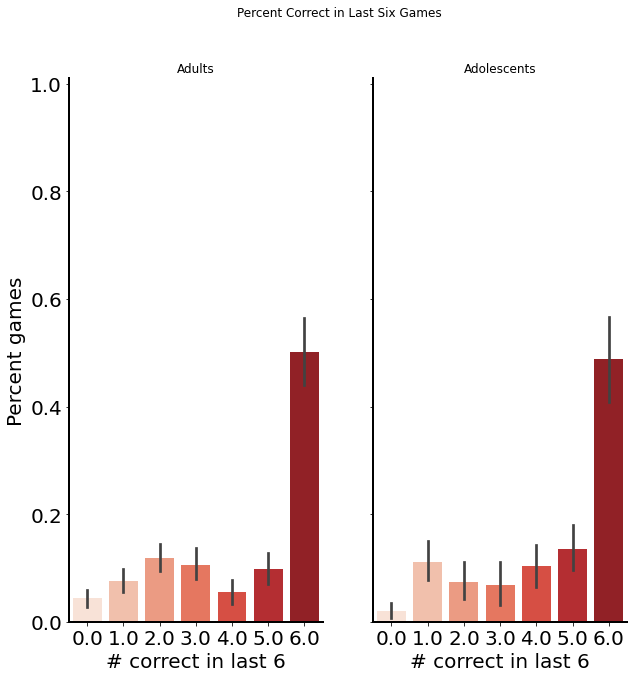

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Percent Correct in Last Six Games')
b1 = sns.barplot(ax = ax1, x="Correct", y="Game", data=adult_df_last_6, palette="Reds",ci=95);
ax1.set_title('Adults')
b2 = sns.barplot(ax = ax2, x="Correct", y="Game", data=adole_df_last_6, palette="Reds",ci=95);
b2.set(ylabel=None)
ax2.set_title('Adolescents')
sns.despine()
ax1.set_ylim([0,1.01])
ax1.set_xlabel('# correct in last 6',fontsize = 20);
ax1.set_ylabel('Percent games',fontsize = 20);
ax2.set_xlabel('# correct in last 6',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)

In [144]:
# separate adults and adolescents in learned vs not learned
learned_adole_df = adole_behav_data.loc[adole_behav_data['LearnedFeat']]
notlearned_adole_df = adole_behav_data.loc[adole_behav_data['LearnedFeat'] == False]

learned_adult_df = adult_behav_data.loc[adult_behav_data['LearnedFeat']]
notlearned_adult_df = adult_behav_data.loc[adult_behav_data['LearnedFeat'] == False]

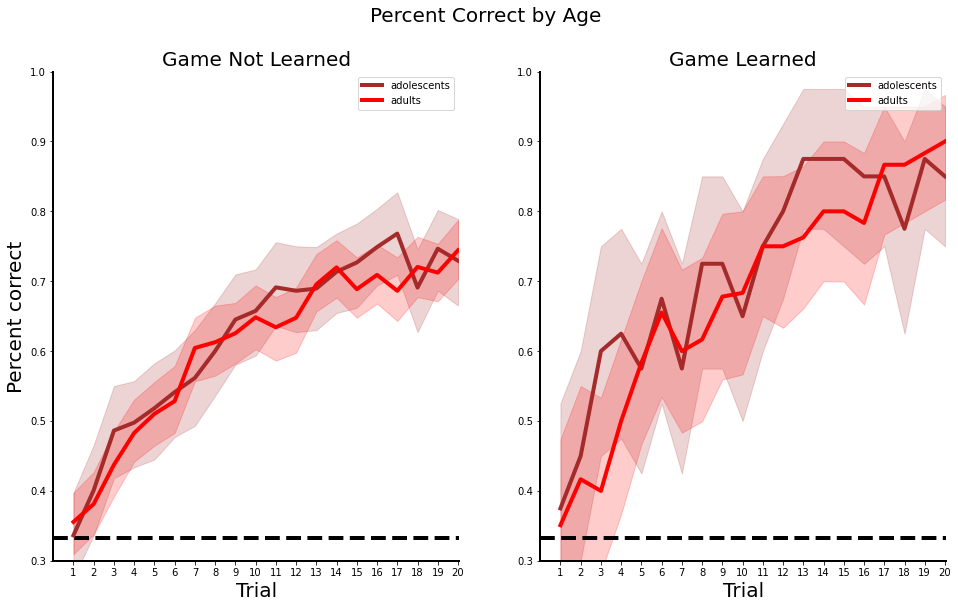

In [145]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['Correct'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Percent Correct by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)
ax1.axhline(y=1/3, color='k', lw=4, linestyle='--');
ax2.axhline(y=1/3, color='k', lw=4, linestyle='--');

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0.3,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0.3, 1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Percent correct',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

# Relative Looking Time Analyses

In [22]:
## Define global variables ##
et_data_dir = os.getcwd() + '/ProcessedData/'# this expects ProcessedData to be in the analysis repo
image_dir = os.getcwd().strip('ldm-analysis') + 'FinalStimuli/ByNumber/'
raw_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/' # this expects RawData to be one directory up from the analysis repo

## Define screen metadata.
xdim, ydim, n_screens = 1280, 1024, 1 
aoisidelength = 162
n_aois = 9

# Define list with all subject ids; remove 33, 66, and 58 for ec and preproc troubles
good_subjects =  [23, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 53, 54, 
                 55, 57, 60, 61, 62, 63, 67, 68, 69, 70, 71];

In [23]:
looking_time_df = {}
for subj_id in good_subjects:
    fixations = pd.read_csv(et_data_dir + str(subj_id) + 'fixations.csv')
    print(fixations)
    duration_summary = fixations.groupby(['Trial', 'Block','Feature'])['Duration'].sum()
    looking_time_df['Sub' + str(subj_id)] = duration_summary
looking_time_df = pd.DataFrame(looking_time_df).fillna(0).reset_index()

      Unnamed: 0  Trial   AoI  Onset  Offset  Duration  Feature  Block
0              0    1.0  10.0  0.056   0.068     0.012     10.0      1
1              1    1.0   6.0  0.072   0.088     0.016      2.0      1
2              2    1.0   5.0  0.092   0.120     0.028      7.0      1
3              3    1.0   4.0  0.124   0.328     0.204      5.0      1
4              4    1.0   5.0  0.332   0.336     0.004      7.0      1
...          ...    ...   ...    ...     ...       ...      ...    ...
6916         629  400.0   5.0  2.564   2.616     0.052      9.0     10
6917         630  400.0  10.0  2.620   2.628     0.008     10.0     10
6918         631  400.0   5.0  2.632   2.732     0.100      9.0     10
6919         632  400.0  10.0  2.736   3.628     0.892     10.0     10
6920         633  400.0   4.0  3.632   4.008     0.376      6.0     10

[6921 rows x 8 columns]
      Unnamed: 0  Trial   AoI  Onset  Offset  Duration  Feature  Block
0              0    1.0   5.0  0.000   0.208     0.2

In [24]:
looking_time_df = pd.wide_to_long(looking_time_df, 'Sub', i=['Trial', 'Block', 'Feature'], j="Subj").rename(columns={"Sub": "Duration"}).unstack(level='Feature').reset_index()
# looking_time_df.to_csv(et_data_dir + 'OrganizedLookingTimes.csv')
looking_time_df

Trial Block Subj Duration                                            \
Feature                        1.0    2.0    3.0    4.0    5.0    6.0    7.0   
0          1.0     1   23    0.224  0.904  0.000  0.000  0.568  0.000  1.688   
1          1.0     1   26    0.000  0.000  0.196  0.000  0.208  0.228  2.260   
2          1.0     1   27    0.000  0.000  1.320  0.000  0.028  0.000  0.000   
3          1.0     1   28    1.432  0.000  0.000  0.000  0.268  0.000  0.000   
4          1.0     1   29    0.196  0.000  0.080  0.008  0.156  0.232  1.600   
...        ...   ...  ...      ...    ...    ...    ...    ...    ...    ...   
13995    400.0    10   67    0.400  0.684  0.988  1.260  0.000  0.024  0.000   
13996    400.0    10   68    0.000  0.000  0.000  0.000  0.000  1.237  0.651   
13997    400.0    10   69    0.000  0.000  0.000  0.000  0.000  0.332  0.368   
13998    400.0    10   70    1.180  0.000  0.568  0.000  0.328  1.460  0.000   
13999    400.0    10   71    0.000  0.000  0.016  0.000  0.000  0.000  0.724   

                              
Feature    8.0    9.0   10.0  
0        0.028  0.000  0.364  
1        0.000  0.260  0.420  
2        0.000  2.200  0.236  
3        0.264  1.068  0.784  
4        0.000  0.900  0.100  
...        ...    ...    ...  
13995    0.000  0.000  0.564  
13996    1.695  0.000  0.415  
13997    0.716  2.516  0.032  
13998    0.000  0.000  0.388  
13999    0.720  2.156  0.248  

[14000 rows x 13 columns]

In [25]:
# using to look at chosen features on trials
sub = behav_data.loc[behav_data['Subj'] == 39,['Trial','Chosen1','Chosen2','Chosen3','Feat']]
sub.loc[sub['Trial'] == (9*40)+1]

,Trial,Chosen1,Chosen2,Chosen3,Feat
5560,361,2.0,5.0,9.0,5


In [26]:
for index, row in looking_time_df.iterrows():
    total_looking_time = row.Duration.sum()
    looking_time_df.loc[index, 'TotalLookingTime'] = total_looking_time
looking_time_df.columns = looking_time_df.columns.to_flat_index()
looking_time_df = looking_time_df.rename(columns={('Duration',  1.0): 'Feature1',('Duration',  2.0): 'Feature2', ('Duration',  3.0): 'Feature3',
                        ('Duration',  4.0): 'Feature4',('Duration',  5.0): 'Feature5', ('Duration',  6.0): 'Feature6',
                        ('Duration',  7.0): 'Feature7',('Duration',  8.0): 'Feature8', ('Duration',  9.0): 'Feature9',
                        ('Duration',  10.0): 'Feature10', ('Trial', ''):'Trial', ('Block', ''):'Block',
                        ('Subj', ''):'Subj', ('TotalLookingTime', ''):'TotalLookingTime'})

In [27]:
looking_time_df

,Trial,Block,Subj,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,TotalLookingTime
0,1.0,1,23,0.224,0.904,0.000,0.000,0.568,0.000,1.688,0.028,0.000,0.364,3.776
1,1.0,1,26,0.000,0.000,0.196,0.000,0.208,0.228,2.260,0.000,0.260,0.420,3.572
2,1.0,1,27,0.000,0.000,1.320,0.000,0.028,0.000,0.000,0.000,2.200,0.236,3.784
3,1.0,1,28,1.432,0.000,0.000,0.000,0.268,0.000,0.000,0.264,1.068,0.784,3.816
4,1.0,1,29,0.196,0.000,0.080,0.008,0.156,0.232,1.600,0.000,0.900,0.100,3.272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,400.0,10,67,0.400,0.684,0.988,1.260,0.000,0.024,0.000,0.000,0.000,0.564,3.920
13996,400.0,10,68,0.000,0.000,0.000,0.000,0.000,1.237,0.651,1.695,0.000,0.415,3.998
13997,400.0,10,69,0.000,0.000,0.000,0.000,0.000,0.332,0.368,0.716,2.516,0.032,3.964
13998,400.0,10,70,1.180,0.000,0.568,0.000,0.328,1.460,0.000,0.000,0.000,0.388,3.924


In [28]:
relative_looking_time_df = looking_time_df
# relative_looking_time_df.columns = looking_time_df.columns.to_flat_index()
# relative_looking_time_df = relative_looking_time_df.rename(columns={('Duration',  1.0): 'Feature1',('Duration',  2.0): 'Feature2', ('Duration',  3.0): 'Feature3',
#                         ('Duration',  4.0): 'Feature4',('Duration',  5.0): 'Feature5', ('Duration',  6.0): 'Feature6',
#                         ('Duration',  7.0): 'Feature7',('Duration',  8.0): 'Feature8', ('Duration',  9.0): 'Feature9',
#                         ('Duration',  10.0): 'Feature10', ('Trial', ''):'Trial', ('Block', ''):'Block',
#                         ('Subj', ''):'Subj', ('TotalLookingTime', ''):'TotalLookingTime'})

In [29]:
relative_looking_time_df = looking_time_df

for featnum in np.arange(10)+1:
    relative_looking_time_df['Feature'+ str(featnum)] = relative_looking_time_df['Feature'+ str(featnum)]/relative_looking_time_df['TotalLookingTime']
relative_looking_time_df = relative_looking_time_df.drop(columns='TotalLookingTime')

In [30]:
lt_example = looking_time_df.loc[looking_time_df['Subj'] == 39]
lt_example = lt_example.loc[lt_example['Block'] == 10]
lt_example = lt_example.loc[lt_example['Trial'] == (9*40)+1]
lt_example

,Trial,Block,Subj,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,TotalLookingTime
12612,361.0,10,39,0.0,0.305361,0.065268,0.0,0.002331,0.0,0.0,0.008159,0.455711,0.16317,3.432


In [31]:
lt_example = pd.wide_to_long(lt_example, 'Feature', i=['Trial', 'Block', 'Subj'], j="FeatureNumber")

In [32]:
lt_example.columns = lt_example.columns.to_flat_index()
lt_example = lt_example.reset_index().rename(columns={'Feature':'LookingTime'})

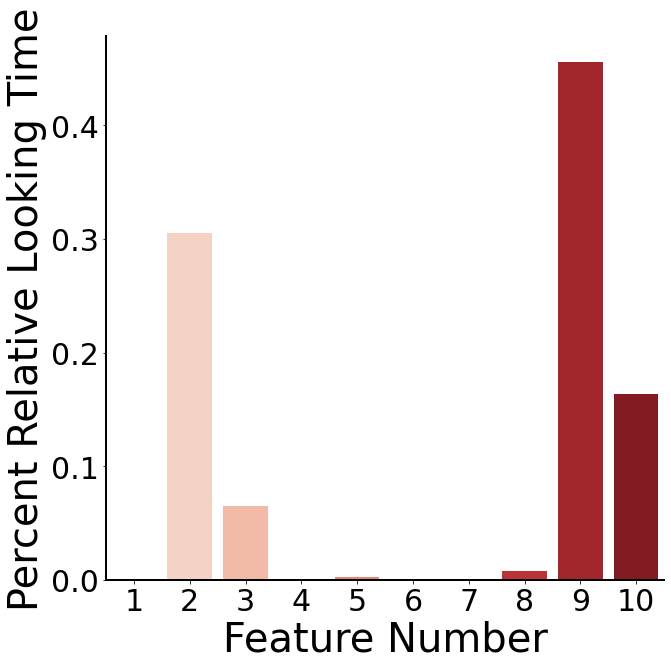

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x="FeatureNumber", y="LookingTime", data=lt_example, palette="Reds",ci=95);
sns.despine()
# ax.set_ylim([0,1.01])
xl = ax.set_xlabel('Feature Number',fontsize = 40);
yl = ax.set_ylabel('Percent Relative Looking Time',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(labelsize=30)

# Calculate Entropy

In [34]:
len(adult_behav_data)

10000

## Entropy across Features

In [35]:
entropy_col = []
for index, row in relative_looking_time_df.iterrows():
    curr_entropy = entropy([row.Feature1, row.Feature2, row.Feature3, row.Feature4, row.Feature5, row.Feature6, row.Feature7, row.Feature8, row.Feature9], base=9)
    entropy_col.append(curr_entropy)
relative_looking_time_df['FeatureEntropy'] = entropy_col

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


## Entropy Across Dimensions

In [36]:
# sum relative looking time over dimensions
relative_looking_time_df['Animals'] = relative_looking_time_df['Feature1'] + relative_looking_time_df['Feature2'] + relative_looking_time_df['Feature3']
relative_looking_time_df['Landscapes'] = relative_looking_time_df['Feature4'] + relative_looking_time_df['Feature5'] + relative_looking_time_df['Feature6']
relative_looking_time_df['Objects'] = relative_looking_time_df['Feature7'] + relative_looking_time_df['Feature8'] + relative_looking_time_df['Feature9']

entropy_col = []
for index, row in relative_looking_time_df.iterrows():
    curr_entropy = entropy([row.Animals, row.Landscapes, row.Objects], base=3)
    entropy_col.append(curr_entropy)
relative_looking_time_df['DimensionEntropy'] = entropy_col

In [37]:
relative_looking_time_df

,Trial,Block,Subj,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
0,1.0,1,23,0.059322,0.239407,0.000000,0.000000,0.150424,0.000000,0.447034,0.007415,0.000000,0.096398,0.553768,0.298729,0.150424,0.454449,0.919397
1,1.0,1,26,0.000000,0.000000,0.054871,0.000000,0.058231,0.063830,0.632699,0.000000,0.072788,0.117581,0.448943,0.054871,0.122060,0.705487,0.569136
2,1.0,1,27,0.000000,0.000000,0.348837,0.000000,0.007400,0.000000,0.000000,0.000000,0.581395,0.062368,0.319683,0.348837,0.007400,0.581395,0.639365
3,1.0,1,28,0.375262,0.000000,0.000000,0.000000,0.070231,0.000000,0.000000,0.069182,0.279874,0.205451,0.522847,0.375262,0.070231,0.349057,0.846596
4,1.0,1,29,0.059902,0.000000,0.024450,0.002445,0.047677,0.070905,0.488998,0.000000,0.275061,0.030562,0.601662,0.084352,0.121027,0.764059,0.600623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,400.0,10,67,0.102041,0.174490,0.252041,0.321429,0.000000,0.006122,0.000000,0.000000,0.000000,0.143878,0.610236,0.528571,0.327551,0.000000,0.605602
13996,400.0,10,68,0.000000,0.000000,0.000000,0.000000,0.000000,0.309405,0.162831,0.423962,0.000000,0.103802,0.469288,0.000000,0.309405,0.586793,0.586605
13997,400.0,10,69,0.000000,0.000000,0.000000,0.000000,0.000000,0.083754,0.092836,0.180626,0.634712,0.008073,0.467065,0.000000,0.083754,0.908174,0.263488
13998,400.0,10,70,0.300714,0.000000,0.144750,0.000000,0.083588,0.372069,0.000000,0.000000,0.000000,0.098879,0.566975,0.445464,0.455657,0.000000,0.630872


# Make one big DF

In [38]:
good_behav_data = behav_data[behav_data['Subj'] != 33]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 66]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 58]
good_behav_data = good_behav_data.reset_index(drop=True)

In [39]:
good_behav_data = behav_data[behav_data['Subj'] != 33]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 66]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 58]
good_behav_data = good_behav_data.reset_index(drop=True)
new_df = pd.merge(good_behav_data, relative_looking_time_df,  how='left', on=['Subj','Trial'])

In [40]:
new_df

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feature6,Feature7,Feature8,Feature9,Feature10,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
0,23,1,1,1,6,8,2,5,7,3,...,0.000000,0.447034,0.007415,0.000000,0.096398,0.553768,0.298729,0.150424,0.454449,0.919397
1,23,2,1,2,5,7,1,4,8,3,...,0.000000,0.138427,0.197121,0.000000,0.019934,0.662668,0.212625,0.431894,0.335548,0.964491
2,23,3,1,3,4,7,2,5,9,1,...,0.000000,0.405690,0.000000,0.242360,0.011591,0.647912,0.144362,0.195996,0.648051,0.799723
3,23,4,1,1,4,7,2,5,8,3,...,0.000000,0.000000,0.487912,0.000000,0.025275,0.444538,0.362637,0.124176,0.487912,0.889076
4,23,5,1,1,6,8,2,4,7,3,...,0.000000,0.439220,0.000000,0.042431,0.017202,0.557065,0.243119,0.258028,0.481651,0.952268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,71,396,20,1,5,7,3,4,9,2,...,0.158747,0.109071,0.000000,0.490281,0.021598,0.592264,0.208423,0.170626,0.599352,0.850333
13996,71,397,20,1,5,8,2,4,9,3,...,0.000000,0.000000,0.000000,0.593079,0.056086,0.411844,0.130072,0.220764,0.593079,0.823688
13997,71,398,20,1,6,7,2,4,9,3,...,0.000000,0.000000,0.124040,0.403952,0.027442,0.602333,0.416026,0.028540,0.527991,0.726755
13998,71,399,20,1,6,7,3,5,8,2,...,0.036677,0.354908,0.266451,0.001079,0.019417,0.690990,0.166127,0.192017,0.622438,0.827024


In [41]:
adole_combined_df = new_df[new_df['Adult'] == False]
adult_combined_df = new_df[new_df['Adult']]

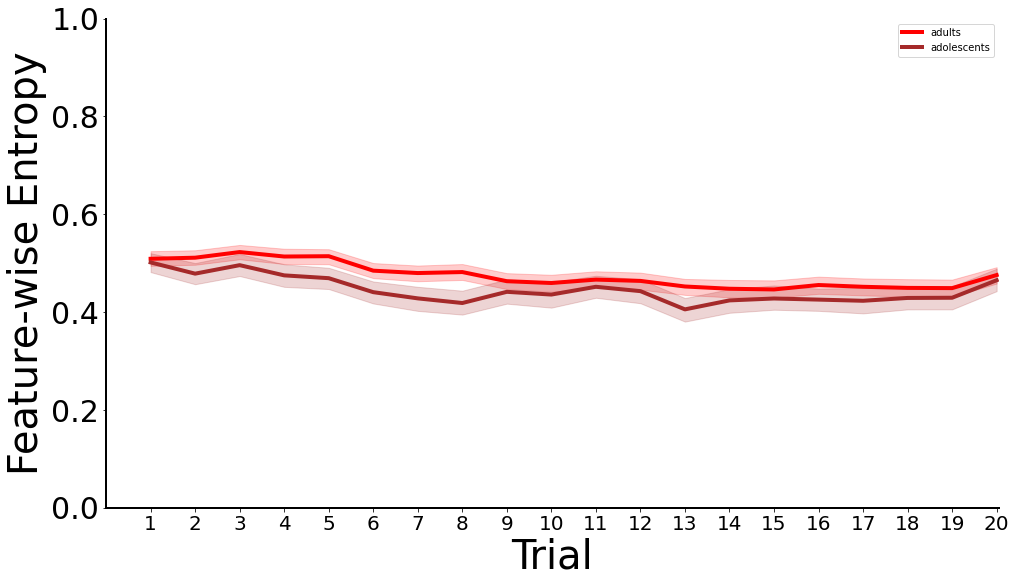

In [42]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Feature-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

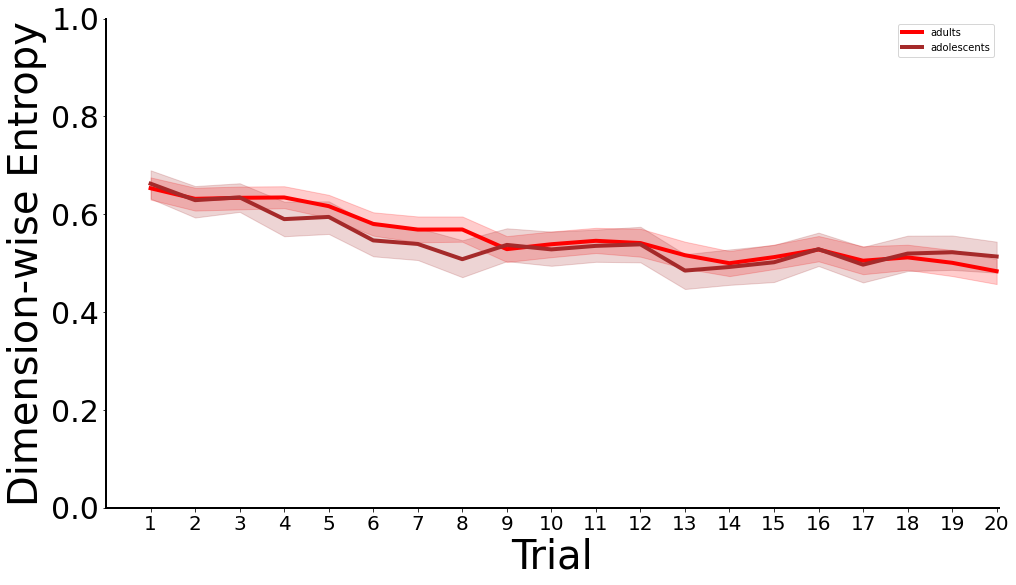

In [43]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Dimension-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

In [44]:
# separate adults and adolescents in learned vs not learned
learned_adole_df = adole_combined_df.loc[adole_combined_df['LearnedFeat']]
notlearned_adole_df = adole_combined_df.loc[adole_combined_df['LearnedFeat'] == False]

learned_adult_df = adult_combined_df.loc[adult_combined_df['LearnedFeat']]
notlearned_adult_df = adult_combined_df.loc[adult_combined_df['LearnedFeat'] == False]

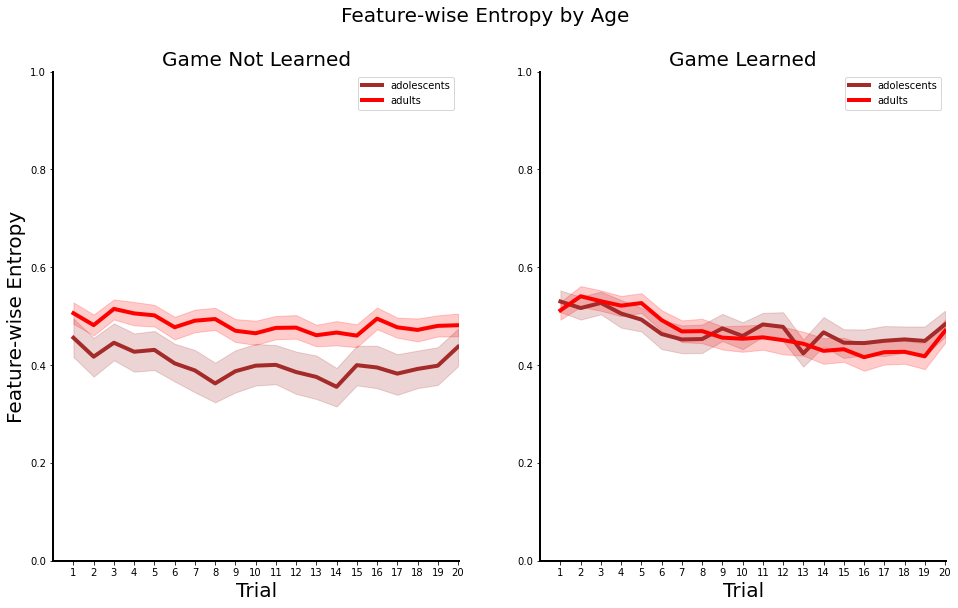

In [45]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Feature-wise Entropy by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0,1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Feature-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

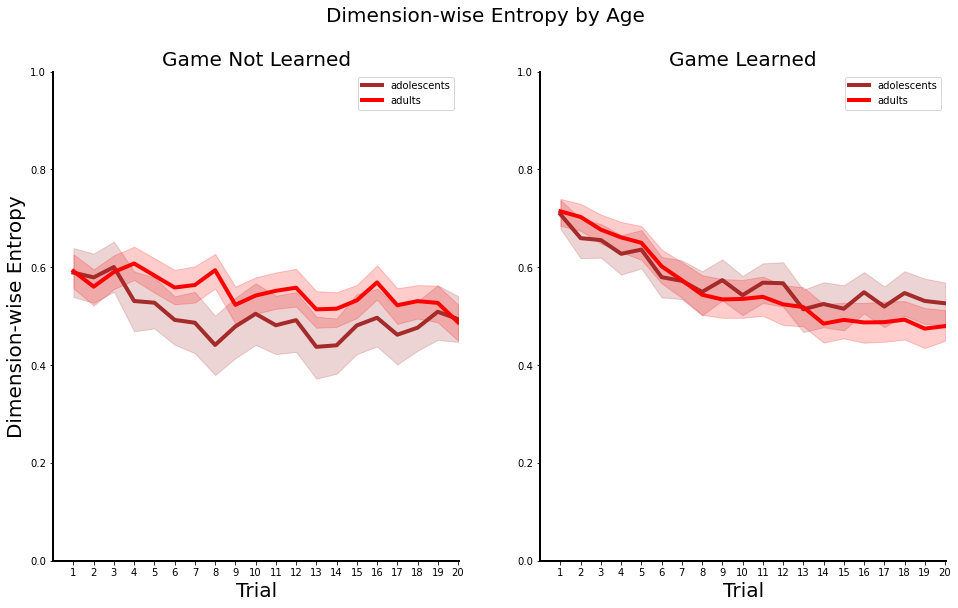

In [46]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Dimension-wise Entropy by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0,1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Dimension-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

# Look across Games

In [47]:
new_df.keys()

Index(['Subj', 'Trial', 'Game', 'Stim11', 'Stim12', 'Stim13', 'Stim21',
       'Stim22', 'Stim23', 'Stim31', 'Stim32', 'Stim33', 'Choice', 'Chosen1',
       'Chosen2', 'Chosen3', 'Unchosen1', 'Unchosen2', 'Unchosen3',
       'Unchosen4', 'Unchosen5', 'Unchosen6', 'Outcome', 'Dim', 'Feat',
       'CenterDim', 'CenterFeat', 'Correct', 'LearnedFeat', 'PoL', 'RT',
       'WithinGameTrial', 'Adult', 'Age', 'Block', 'Feature1', 'Feature2',
       'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8',
       'Feature9', 'Feature10', 'FeatureEntropy', 'Animals', 'Landscapes',
       'Objects', 'DimensionEntropy'],
      dtype='object')

In [48]:
adole_combined_df
adult_combined_df

,Subj,Trial,Game,Stim11,Stim12,Stim13,Stim21,Stim22,Stim23,Stim31,...,Feature6,Feature7,Feature8,Feature9,Feature10,FeatureEntropy,Animals,Landscapes,Objects,DimensionEntropy
400,26,1,1,1,4,8,2,5,9,3,...,0.063830,0.632699,0.000000,0.072788,0.117581,0.448943,0.054871,0.122060,0.705487,0.569136
401,26,2,1,2,4,8,3,6,9,1,...,0.488863,0.065651,0.000000,0.257913,0.106682,0.508812,0.004689,0.565064,0.323564,0.623605
402,26,3,1,1,6,7,3,5,8,2,...,0.000000,0.000000,0.064626,0.465986,0.078231,0.508420,0.085034,0.306122,0.530612,0.822715
403,26,4,1,3,5,7,1,6,9,2,...,0.301843,0.000000,0.000000,0.436636,0.154378,0.481781,0.054147,0.354839,0.436636,0.802538
404,26,5,1,1,6,9,2,4,8,3,...,0.254797,0.000000,0.153518,0.514925,0.076759,0.445685,0.000000,0.254797,0.668443,0.536238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,71,396,20,1,5,7,3,4,9,2,...,0.158747,0.109071,0.000000,0.490281,0.021598,0.592264,0.208423,0.170626,0.599352,0.850333
13996,71,397,20,1,5,8,2,4,9,3,...,0.000000,0.000000,0.000000,0.593079,0.056086,0.411844,0.130072,0.220764,0.593079,0.823688
13997,71,398,20,1,6,7,2,4,9,3,...,0.000000,0.000000,0.124040,0.403952,0.027442,0.602333,0.416026,0.028540,0.527991,0.726755
13998,71,399,20,1,6,7,3,5,8,2,...,0.036677,0.354908,0.266451,0.001079,0.019417,0.690990,0.166127,0.192017,0.622438,0.827024


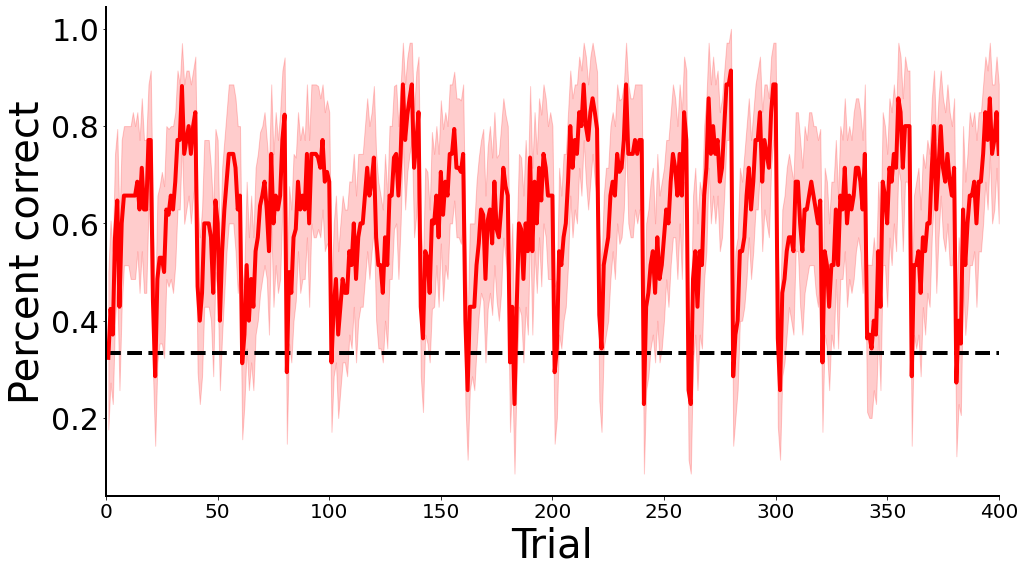

In [49]:
df = pd.melt(new_df, col_level=0, id_vars='Trial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
ax.axhline(y=1/3, color='k', lw=4, linestyle='--');
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=df, lw=4, legend=False, color='red')
sns.despine()
ax.set_xlim([0,400+.05])
# ax.set_ylim([0.3,0.8])
# ax.set_xticks(np.arange(400)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Percent correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

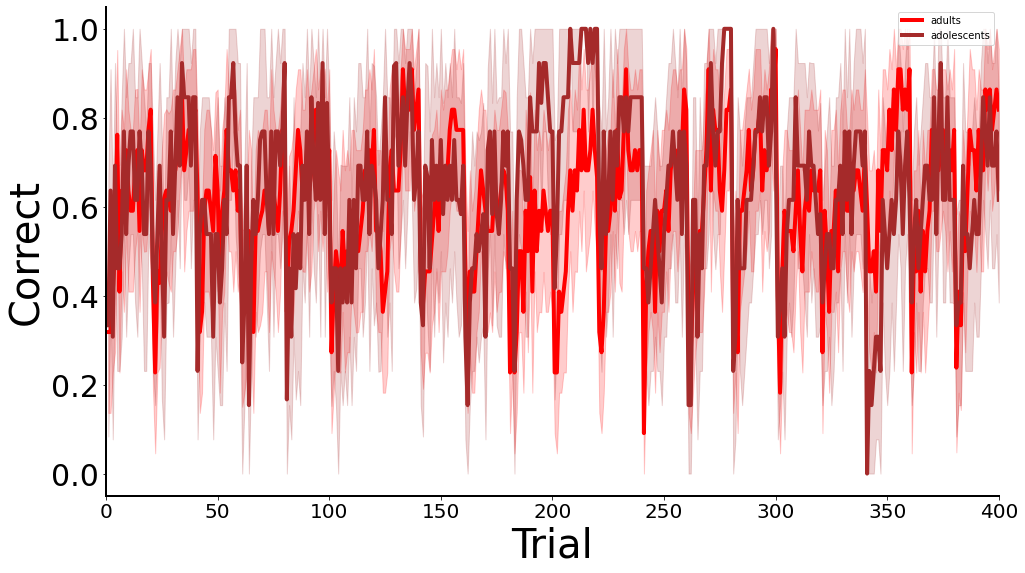

In [50]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='Trial', value_vars=['Correct'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,400+.05])
# ax.set_ylim([0.3,1])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Correct',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

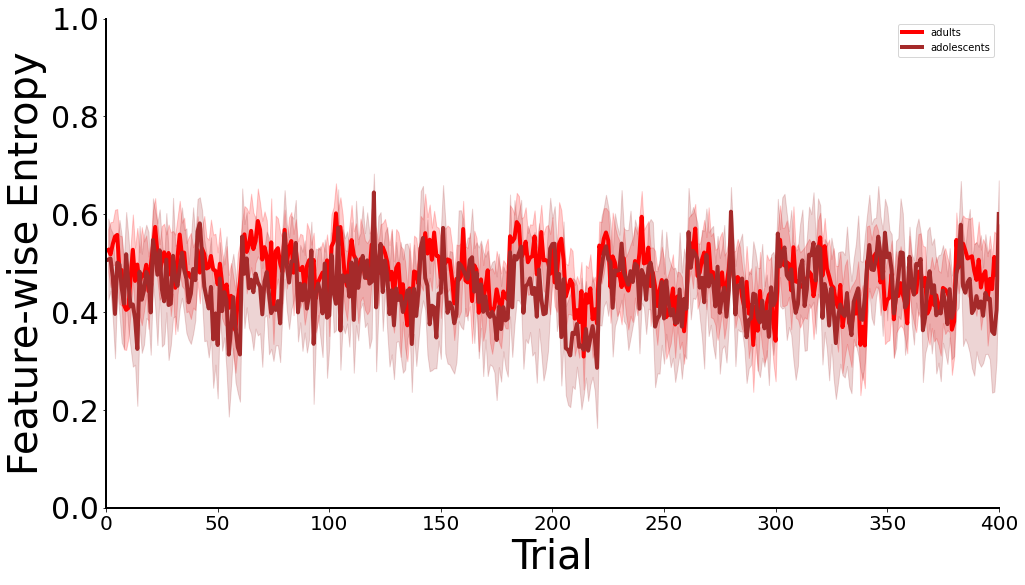

In [51]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,400+.05])
ax.set_ylim([0,1])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Feature-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

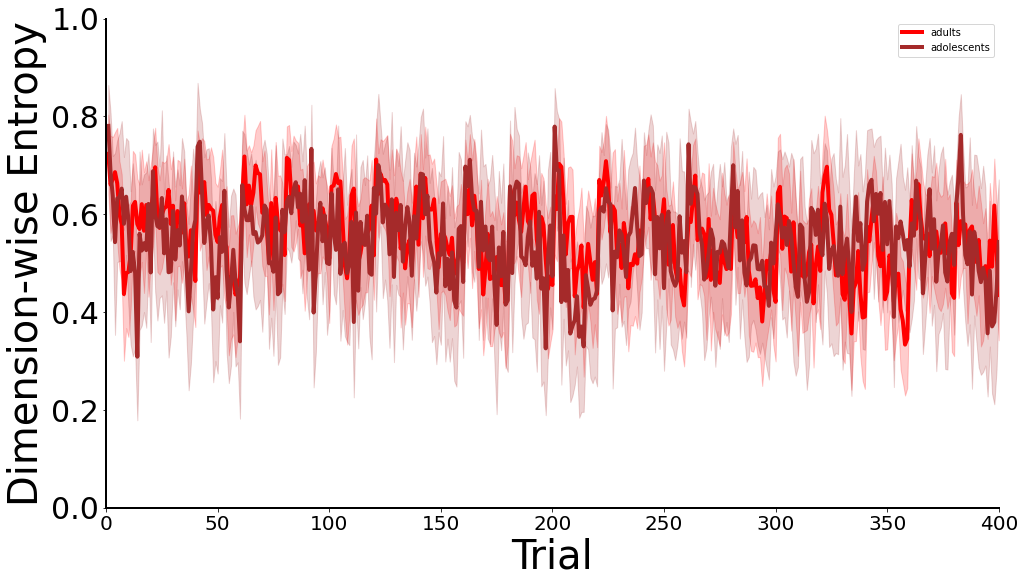

In [52]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'Trial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,400+.05])
ax.set_ylim([0,1])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Dimension-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

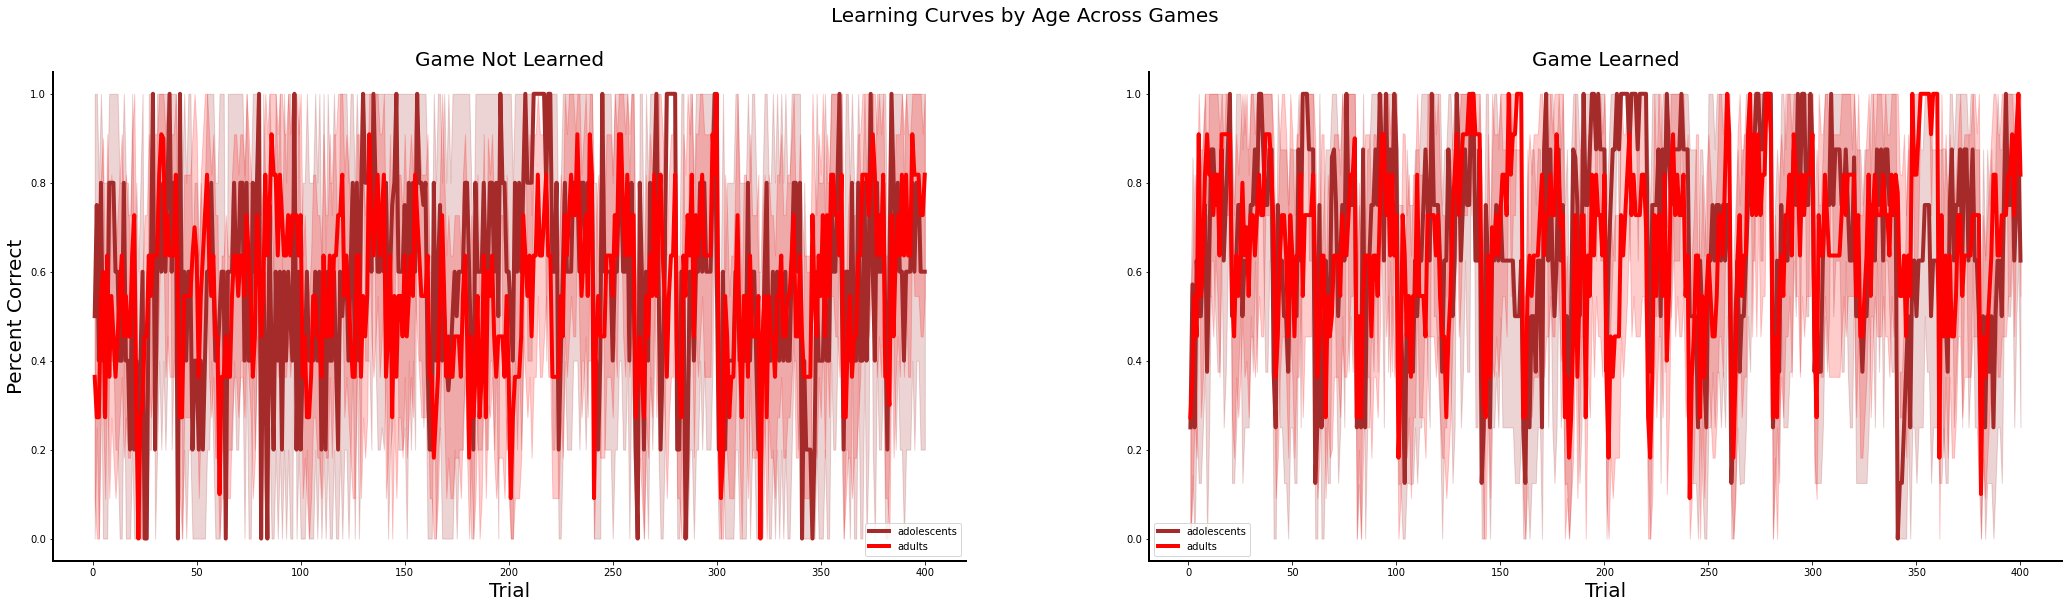

In [53]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='Trial', value_vars=['Correct'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='Trial', value_vars=['Correct'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(36,9))
fig.suptitle('Learning Curves by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# # ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([-0.5,1.5])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax1.set_ylim([-0.5,1.5])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Percent Correct',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

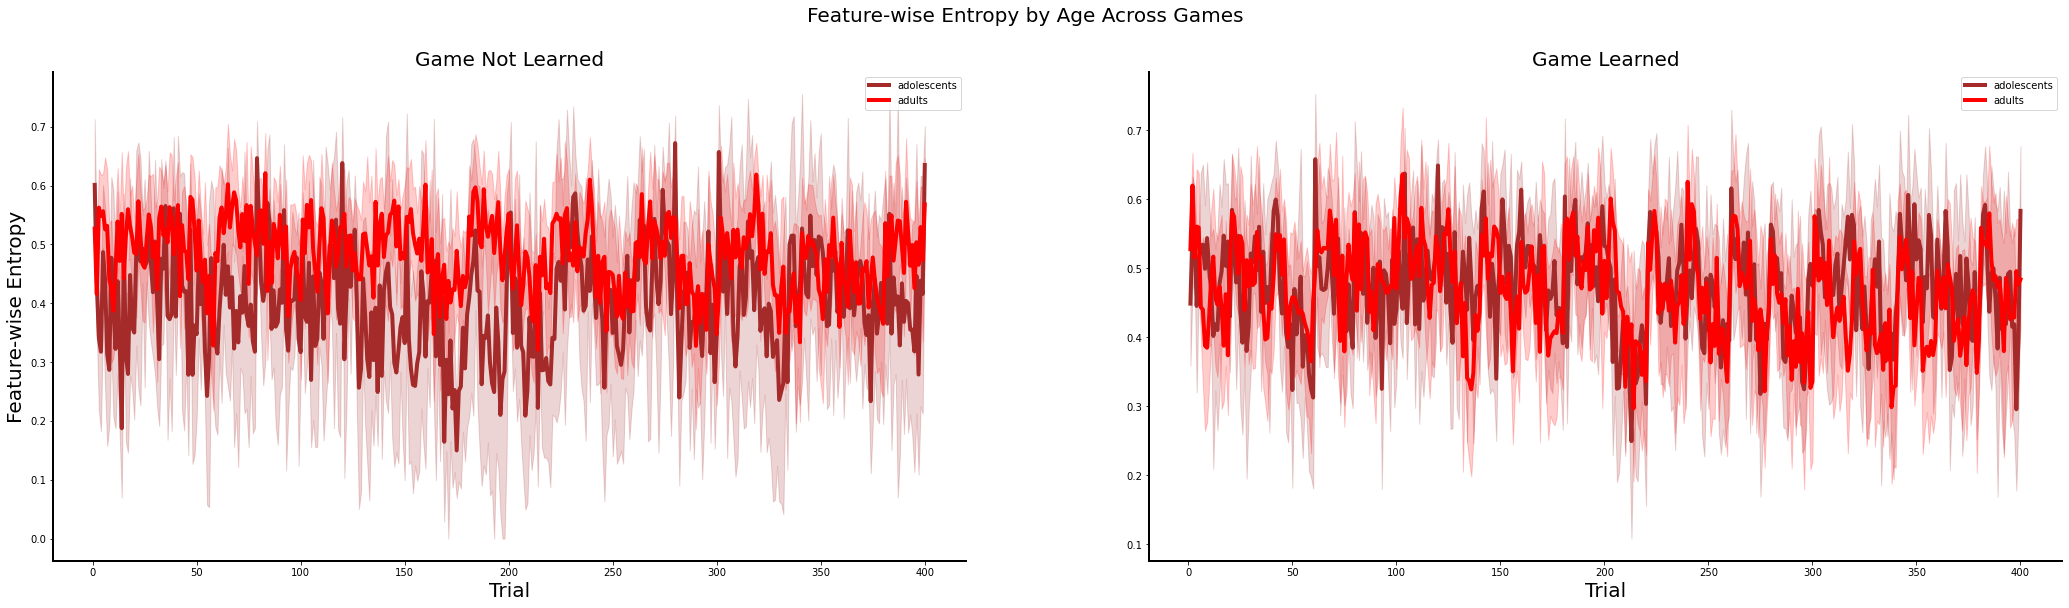

In [54]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='Trial', value_vars=['FeatureEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(36,9))
fig.suptitle('Feature-wise Entropy by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Feature-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

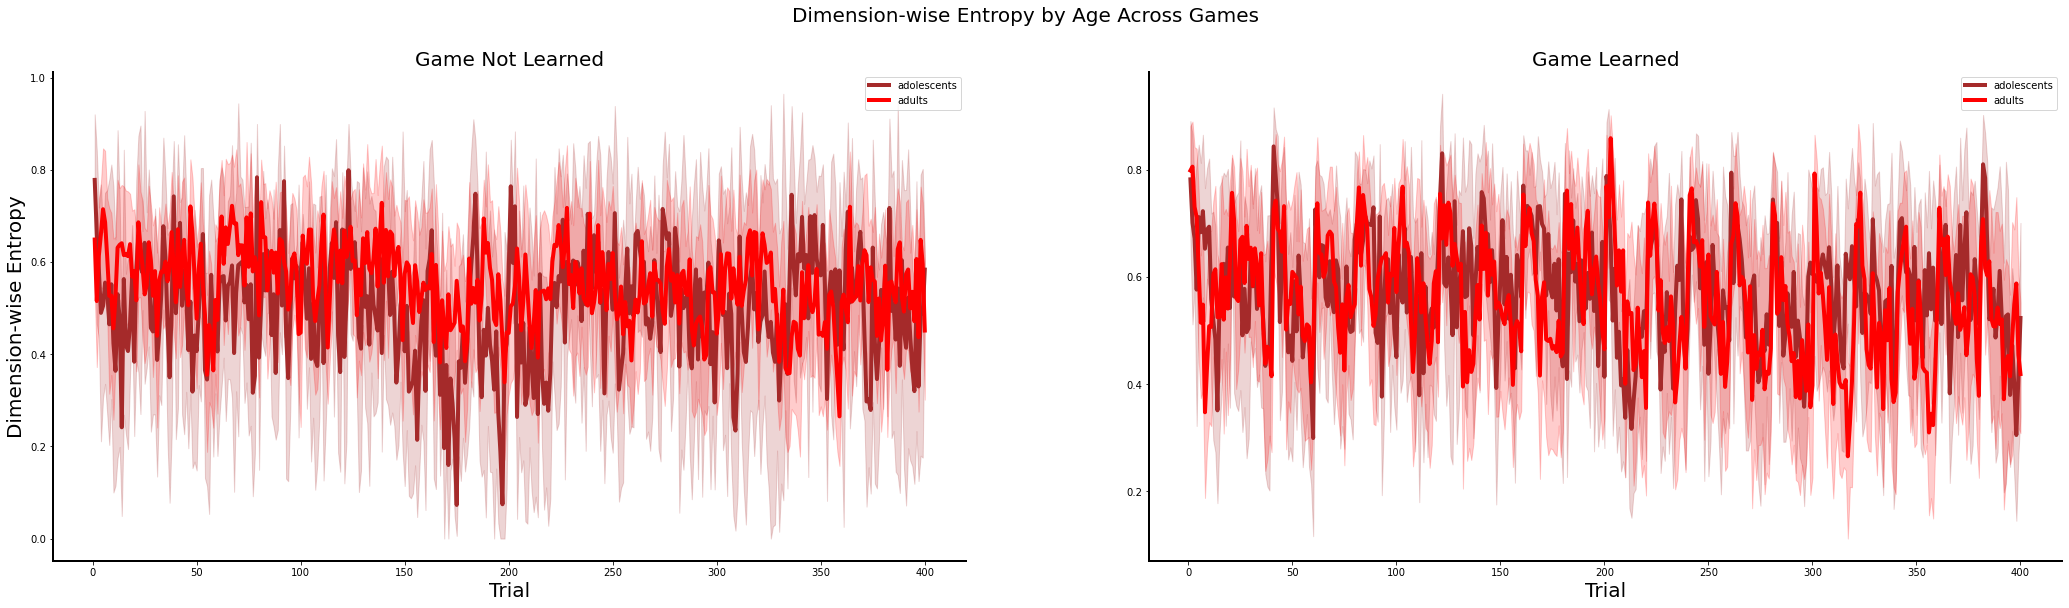

In [55]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='Trial', value_vars=['DimensionEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(36,9))
fig.suptitle('Dimension-wise Entropy by Age Across Games',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'Trial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
# ax1.set_xlim([0,game_length+.05])
# ax1.set_ylim([0,1])
# ax1.set_xticks(np.arange(game_length)+1)
# ax2.set_xlim([0,game_length+.05])
# ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Dimension-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

# Reaction Time Analyses

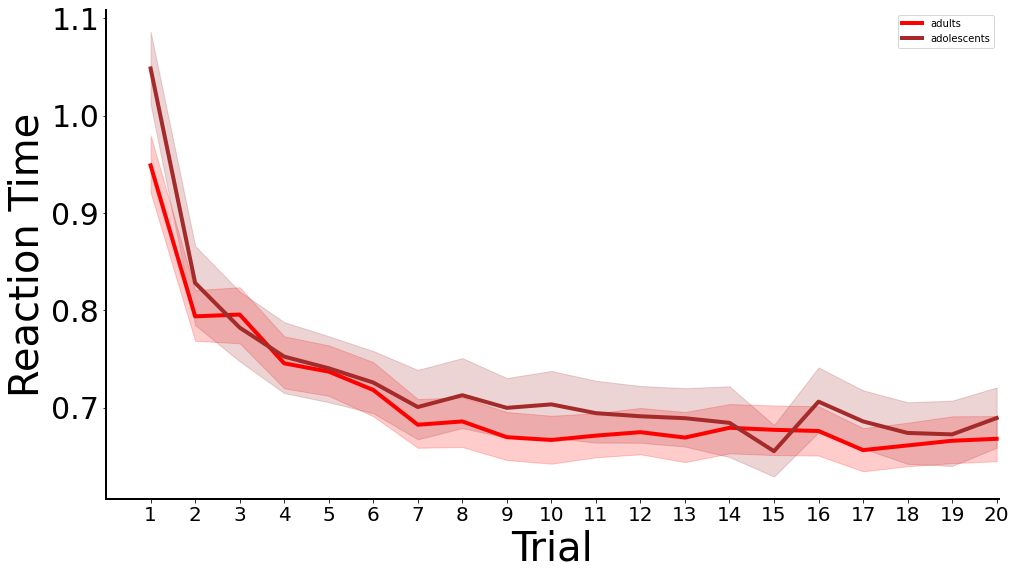

In [56]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['RT'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['RT'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
# ax.set_ylim([0,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Reaction Time',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

# Relative looking time analyses with pre-choice fixations

In [167]:
## Define global variables ##
et_data_dir = os.getcwd() + '/ProcessedData/'# this expects ProcessedData to be in the analysis repo
image_dir = os.getcwd().strip('ldm-analysis') + 'FinalStimuli/ByNumber/'
raw_data_dir = os.getcwd().strip('ldm-analysis') + 'RawData/' # this expects RawData to be one directory up from the analysis repo

## Define screen metadata.
xdim, ydim, n_screens = 1280, 1024, 1 
aoisidelength = 162
n_aois = 9

# Define list with all subject ids; remove 33, 66, and 58 for ec and preproc troubles
good_subjects =  [23, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 53, 54, 
                 55, 57, 60, 61, 62, 63, 67, 68, 69, 70, 71];

In [168]:
pre_choice_looking_time_df = {}
for subj_id in good_subjects:
    fixations = pd.read_csv(et_data_dir + str(subj_id) + 'pre-choice_fixations.csv')
    duration_summary = fixations.groupby(['Trial', 'Block','Feature'])['Duration'].sum()
    pre_choice_looking_time_df['Sub' + str(subj_id)] = duration_summary
pre_choice_looking_time_df = pd.DataFrame(pre_choice_looking_time_df).fillna(0).reset_index()

In [169]:
pre_choice_looking_time_df = pd.wide_to_long(pre_choice_looking_time_df, 'Sub', i=['Trial', 'Block', 'Feature'], j="Subj").rename(columns={"Sub": "Duration"}).unstack(level='Feature').reset_index()

In [170]:
for index, row in pre_choice_looking_time_df.iterrows():
    total_looking_time = row.Duration.sum()
    pre_choice_looking_time_df.loc[index, 'TotalLookingTime'] = total_looking_time
pre_choice_looking_time_df.columns = pre_choice_looking_time_df.columns.to_flat_index()
pre_choice_looking_time_df = pre_choice_looking_time_df.rename(columns={('Duration',  1.0): 'Feature1',('Duration',  2.0): 'Feature2', ('Duration',  3.0): 'Feature3',
                        ('Duration',  4.0): 'Feature4',('Duration',  5.0): 'Feature5', ('Duration',  6.0): 'Feature6',
                        ('Duration',  7.0): 'Feature7',('Duration',  8.0): 'Feature8', ('Duration',  9.0): 'Feature9',
                        ('Duration',  10.0): 'Feature10', ('Trial', ''):'Trial', ('Block', ''):'Block',
                        ('Subj', ''):'Subj', ('TotalLookingTime', ''):'TotalLookingTime'})

In [171]:
relative_looking_time_df = pre_choice_looking_time_df

for featnum in np.arange(10)+1:
    relative_looking_time_df['Feature'+ str(featnum)] = relative_looking_time_df['Feature'+ str(featnum)]/relative_looking_time_df['TotalLookingTime']
relative_looking_time_df = relative_looking_time_df.drop(columns='TotalLookingTime')

## Entropy across features

In [172]:
entropy_col = []
for index, row in relative_looking_time_df.iterrows():
    curr_entropy = entropy([row.Feature1, row.Feature2, row.Feature3, row.Feature4, row.Feature5, row.Feature6, row.Feature7, row.Feature8, row.Feature9], base=9)
    # curr_entropy = entropy([row.Feature1, row.Feature2, row.Feature3, row.Feature4, row.Feature5, row.Feature6, row.Feature7, row.Feature8, row.Feature9, row.Feature10], base=10)
    entropy_col.append(curr_entropy)
relative_looking_time_df['FeatureEntropy'] = entropy_col

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


## Entropy across dimensions

In [173]:
# sum relative looking time over dimensions
relative_looking_time_df['Animals'] = relative_looking_time_df['Feature1'] + relative_looking_time_df['Feature2'] + relative_looking_time_df['Feature3']
relative_looking_time_df['Landscapes'] = relative_looking_time_df['Feature4'] + relative_looking_time_df['Feature5'] + relative_looking_time_df['Feature6']
relative_looking_time_df['Objects'] = relative_looking_time_df['Feature7'] + relative_looking_time_df['Feature8'] + relative_looking_time_df['Feature9']

entropy_col = []
for index, row in relative_looking_time_df.iterrows():
    curr_entropy = entropy([row.Animals, row.Landscapes, row.Objects], base=3)
    # curr_entropy = entropy([row.Animals, row.Landscapes, row.Objects, row.Feature10], base=4)
    entropy_col.append(curr_entropy)
relative_looking_time_df['DimensionEntropy'] = entropy_col

In [64]:
relative_looking_time_df[['FeatureEntropy','DimensionEntropy']]

,FeatureEntropy,DimensionEntropy
0,0.586062,0.744347
1,0.292815,0.238033
2,0.269645,0.447870
3,0.611774,0.784757
4,0.383267,0.313314
...,...,...
13995,0.084312,0.074454
13996,0.279876,0.464864
13997,0.000000,0.000000
13998,0.000000,0.000000


In [174]:
good_behav_data = behav_data[behav_data['Subj'] != 33]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 66]
good_behav_data = good_behav_data[good_behav_data['Subj'] != 58]
good_behav_data = good_behav_data.reset_index(drop=True)
new_df = pd.merge(good_behav_data, relative_looking_time_df,  how='left', on=['Subj','Trial'])

In [175]:
new_df[['WithinGameTrial', 'FeatureEntropy','DimensionEntropy']].loc[new_df[['WithinGameTrial', 'FeatureEntropy','DimensionEntropy']]['WithinGameTrial'] == 1].mean()

WithinGameTrial     1.000000
FeatureEntropy      0.298084
DimensionEntropy    0.403127
dtype: float64

In [78]:
new_df[['WithinGameTrial', 'FeatureEntropy','DimensionEntropy']].loc[new_df[['WithinGameTrial', 'FeatureEntropy','DimensionEntropy']]['WithinGameTrial'] == 19].mean()

WithinGameTrial     19.000000
FeatureEntropy       0.193816
DimensionEntropy     0.215375
dtype: float64

In [176]:
adole_combined_df = new_df[new_df['Adult'] == False]
adult_combined_df = new_df[new_df['Adult']]

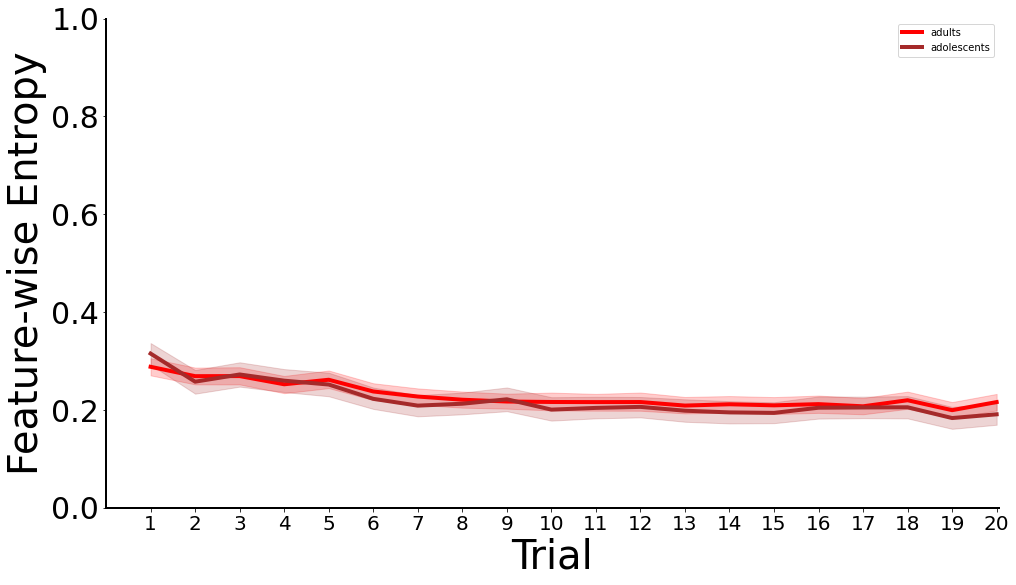

In [177]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Feature-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

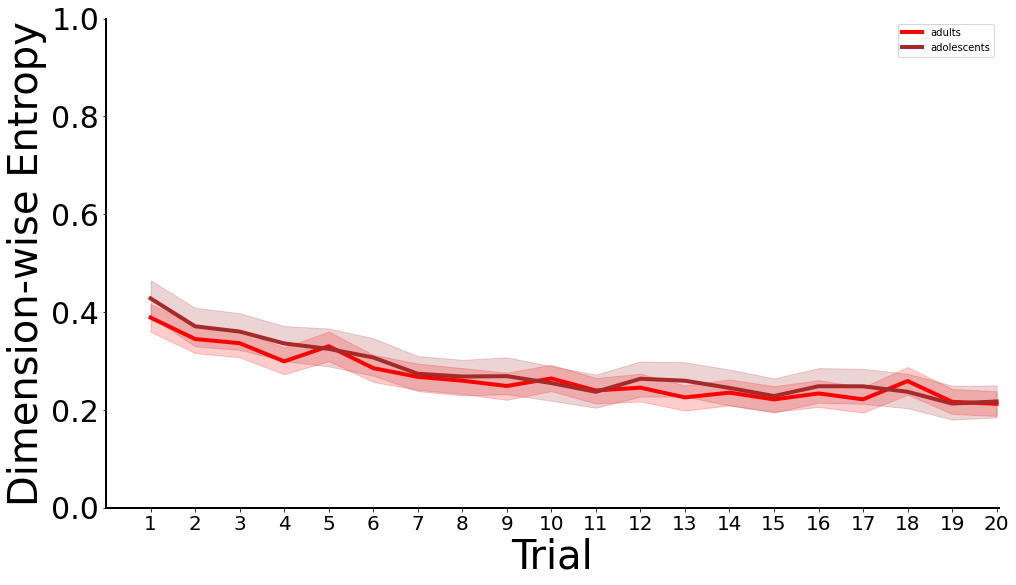

In [178]:
combined_df_adult = pd.melt(adult_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
combined_df_adole = pd.melt(adole_combined_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adult, lw=4, legend='brief', label='adults', color='red')
sns.lineplot(x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=combined_df_adole, lw=4, legend='brief', label='adolescents',  color='brown')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_ylim([0,1])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Dimension-wise Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

In [179]:
# separate adults and adolescents in learned vs not learned
learned_adole_df = adole_combined_df.loc[adole_combined_df['LearnedFeat']]
notlearned_adole_df = adole_combined_df.loc[adole_combined_df['LearnedFeat'] == False]

learned_adult_df = adult_combined_df.loc[adult_combined_df['LearnedFeat']]
notlearned_adult_df = adult_combined_df.loc[adult_combined_df['LearnedFeat'] == False]

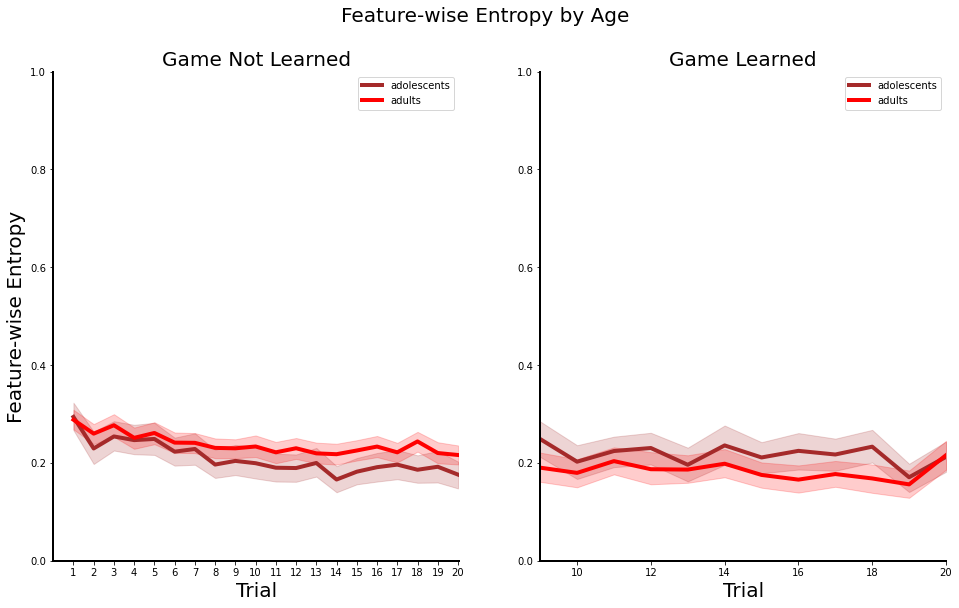

In [183]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['FeatureEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Feature-wise Entropy by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([9,game_length])
ax2.set_ylim([0,1])
# ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Feature-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')

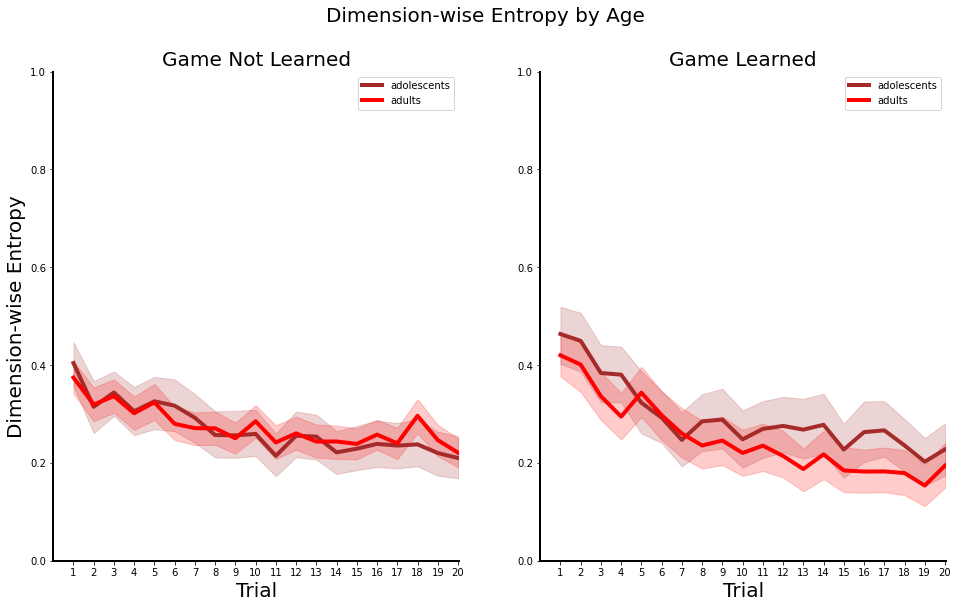

In [181]:
df_adole_learned = pd.melt(learned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adole_notlearned = pd.melt(notlearned_adole_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adult_learned = pd.melt(learned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])
df_adult_notlearned = pd.melt(notlearned_adult_df, col_level=0, id_vars='WithinGameTrial', value_vars=['DimensionEntropy'])

fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,9))
fig.suptitle('Dimension-wise Entropy by Age',fontsize = 20)
ax1.set_title('Game Not Learned',fontsize = 20)
ax2.set_title('Game Learned',fontsize = 20)

l1 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_notlearned, lw=4, legend='brief', label='adolescents', color='brown')
l2 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adole_learned, lw=4, legend='brief', label='adolescents', color='brown')
l3 = sns.lineplot(ax = ax1, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_notlearned, lw=4, legend='brief', label='adults',  color='red')
l4 = sns.lineplot(ax = ax2, x = 'WithinGameTrial', y="value", err_style="band", ci=95, data=df_adult_learned, lw=4, legend='brief', label='adults', color='red')
l2.set(ylabel=None)
sns.despine()
ax1.set_xlim([0,game_length+.05])
ax1.set_ylim([0,1])
ax1.set_xticks(np.arange(game_length)+1)
ax2.set_xlim([0,game_length+.05])
ax2.set_ylim([0,1])
ax2.set_xticks(np.arange(game_length)+1)
xl = ax1.set_xlabel('Trial',fontsize = 20);
yl = ax1.set_ylabel('Dimension-wise Entropy',fontsize = 20);
xl = ax2.set_xlabel('Trial',fontsize = 20);
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
      ax2.spines[axis].set_linewidth(2)
ax1.tick_params(axis='x',colors='k')
ax2.tick_params(axis='x',colors='k')